In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from xgboost import XGBRFRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection      import permutation_importance

from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

from sklearn import tree
from sklearn.tree import export_graphviz
#import graphviz
import shap

import multiprocessing
n_threads=multiprocessing.cpu_count()

from wurlitzer import sys_pipes

import warnings

/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def plot_hist(Y, nbins):
    fig, ax = plt.subplots(figsize=(15,7))

    #b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
    b = np.logspace(np.log10(min(Y)), np.log10(max(Y)), nbins)
    entries, edges, _ = ax.hist(Y_pred, bins=b, density=True, histtype='step', lw=3)

    # calculate bin centers
    bin_centers = 0.5 * (edges[:-1] + edges[1:])

    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title('Distribution of the Delay times')
    ax.set_xlabel('Delay Time [Myr]')
    ax.set_ylabel('PDF')
    ax.grid(ls='dotted', lw=2)
    
    plt.show()

### Read data 

In [3]:
dir        = "DATA/"
file1      = 'BHBH_Delay_Time.csv'

BHBH       = pd.read_csv(dir+file1)
BHBH.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)
BHBH.head()

,Index,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,RemnantType_0,Mass_1,...,Events,EventsPlus,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha,Delay_Time,Eccentricity_Delay
0,0,360308,0_792857804219921,5.411991,18.34303,0.000078,21.22227,7,6,21.09631,...,RB:RE:S:RB:RE:S,RB:RE:ehSt:RB:RE:erSt,41.0592,34.5745,24.874630,0.2619,0.0004,0.5,9.993410e+04,6.409107e-11
1,1,360337,0_285120263308905,4.134819,50.99943,0.000217,92.24360,7,6,51.78028,...,S:S,hhS:hrS,92.2436,53.6410,81917.701038,0.3955,0.0004,0.5,5.520443e+16,4.934820e-14
2,2,360367,0_303570516402716,4.311590,33.98611,0.000144,41.10912,7,6,30.83786,...,RB:RE:RB:RE:S:RB:RE:S,RB:RE:RB:RE:ehSt:RB:RE:erSt,74.5563,46.8471,127.422203,0.2217,0.0004,0.5,7.108337e+05,1.981434e-10
3,3,360429,0_321152334354104,5.738531,42.61480,0.000181,50.85000,7,6,33.31328,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,50.8500,32.3486,316.947946,0.0107,0.0004,0.5,1.214966e+07,2.425785e-12
4,4,360471,0_850952161687565,4.503749,49.74939,0.000211,65.22210,7,6,45.91471,...,RB:S:RE:RB:S,RB:hhS:RE:RB:hrS,65.2221,46.7855,1548.080290,0.0751,0.0004,0.5,5.995947e+09,1.042263e-11


In [4]:
#X = BHBH.drop(['Index', 'ID', 'name', 'Delay_Time',
#               'Eccentricity_Delay',
#               'Events', 'EventsAll', 'EventsPlus'], axis=1).to_numpy()

# define attributes based on knowledge
# should we use the others?
X = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y = BHBH.Delay_Time.to_numpy()

### Split training and test set

In [5]:
# split train and test set (80% training, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
X_train

array([[8.429761e+00, 8.619972e+00, 2.518951e+01, 2.932597e-02,
        6.000000e-03, 3.000000e+00],
       [3.356409e+01, 2.265303e+01, 5.044398e+04, 2.137746e-01,
        2.000000e-04, 3.000000e+00],
       [2.755586e+01, 2.619558e+01, 5.233850e+03, 4.619727e-01,
        4.000000e-03, 3.000000e+00],
       ...,
       [3.273191e+01, 2.267255e+01, 3.502999e+02, 2.903056e-01,
        1.000000e-04, 3.000000e+00],
       [1.374775e+01, 5.700543e+00, 8.896309e+01, 2.752416e-01,
        4.000000e-03, 5.000000e-01],
       [9.183860e+00, 9.479400e+00, 1.243541e+01, 8.879470e-02,
        2.000000e-03, 5.000000e+00]])

## Scikit-learn Random Forest

In [5]:
# model definition for the regressor
# using mostly the default parameters
#regressor=RandomForestRegressor(n_estimators=10, criterion='squared_error',
#                                max_depth=10, min_samples_split=2,
#                                min_samples_leaf=1, min_weight_fraction_leaf=0.0,
#                                max_features=1.0, max_leaf_nodes=None,
#                                min_impurity_decrease=.0, bootstrap=True,
#                                oob_score=False, n_jobs=-1,
#                                random_state=0,
#                                verbose=1)
regressor=RandomForestRegressor(n_estimators = 100, random_state = 42,
                                n_jobs=-1, verbose=3)

In [6]:
# traininig of the model
regressor.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   54.6s


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=3)

In [7]:
# make predictions to compare with Y_test
Y_pred = regressor.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


In [8]:
print('Score of the regressor for the training set:\n', regressor.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   regressor.score(X_test,  Y_test ))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Score of the regressor for the training set:
 0.9649620861915049


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.8s



Score of the regressor for the test set:
 0.950672598145966


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    4.7s finished


In [9]:
print('R^2 Score of the regressor for the test set:\n', r2_score(Y_test,  Y_pred ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(Y_test,  Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(Y_test,  Y_pred ))

R^2 Score of the regressor for the test set:
 0.950672598145966
Mean squared log error of the regressor for the test set:
 0.02123558618292504
Mean squared error of the regressor for the test set:
 1.1970304124953167e+39


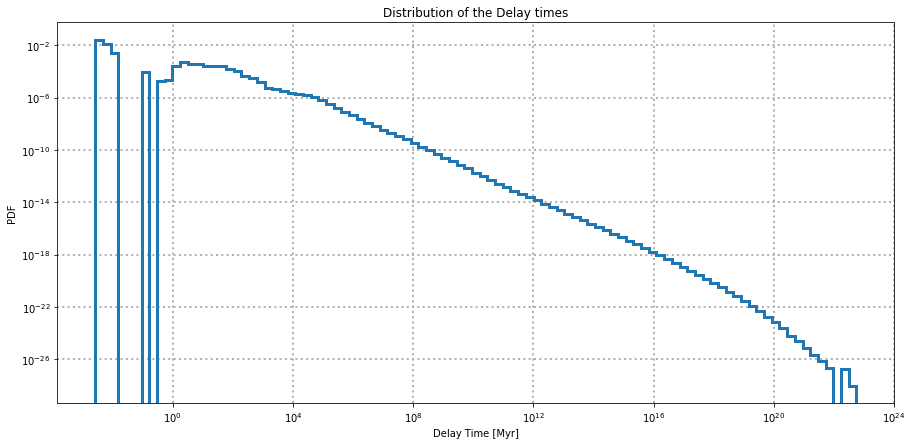

In [16]:
plot_hist(Y_pred, 100)

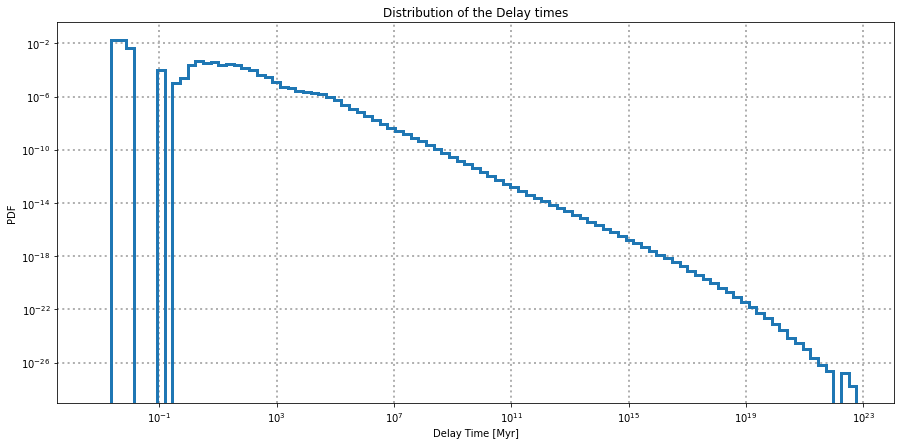

In [17]:
plot_hist(Y_test, 100)

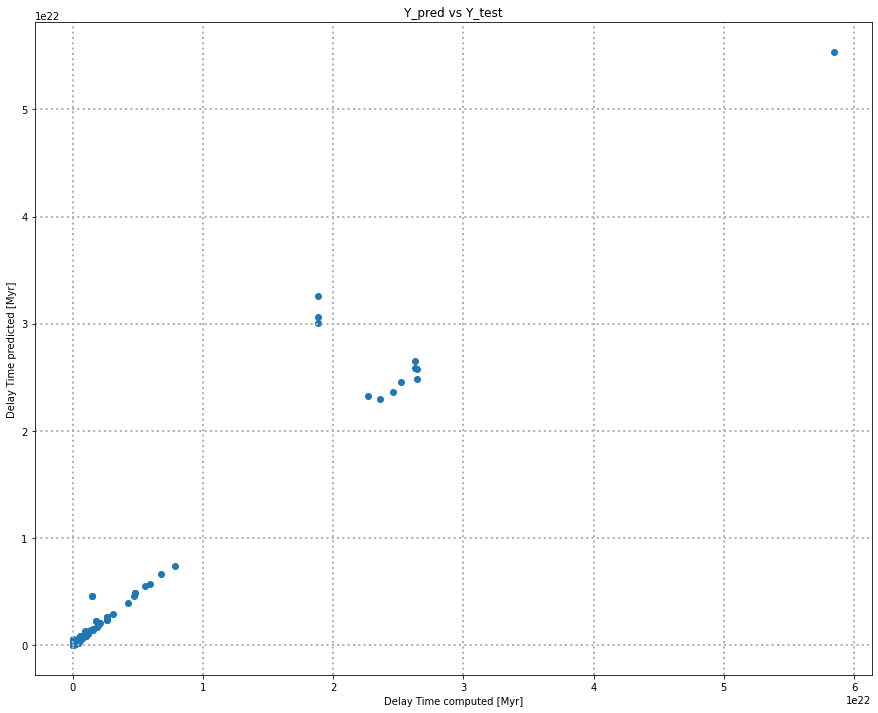

In [12]:
fig, ax = plt.subplots(figsize=(15,12))

ax.scatter(Y_test, Y_pred)

ax.set_title('Y_pred vs Y_test')
ax.set_xlabel('Delay Time computed [Myr]')
ax.set_ylabel('Delay Time predicted [Myr]')
ax.grid(ls='dotted', lw=2)
plt.show()

[0.80777353 0.03218001 0.03404543 0.05854034 0.05358091 0.01387977]


Text(0.5, 0, 'Random Forest Feature Importance')

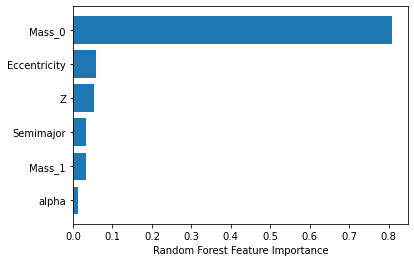

In [13]:
print(regressor.feature_importances_)

features = np.array(['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'])

sorted_idx = regressor.feature_importances_.argsort()
plt.barh(features[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

KeyboardInterrupt: 

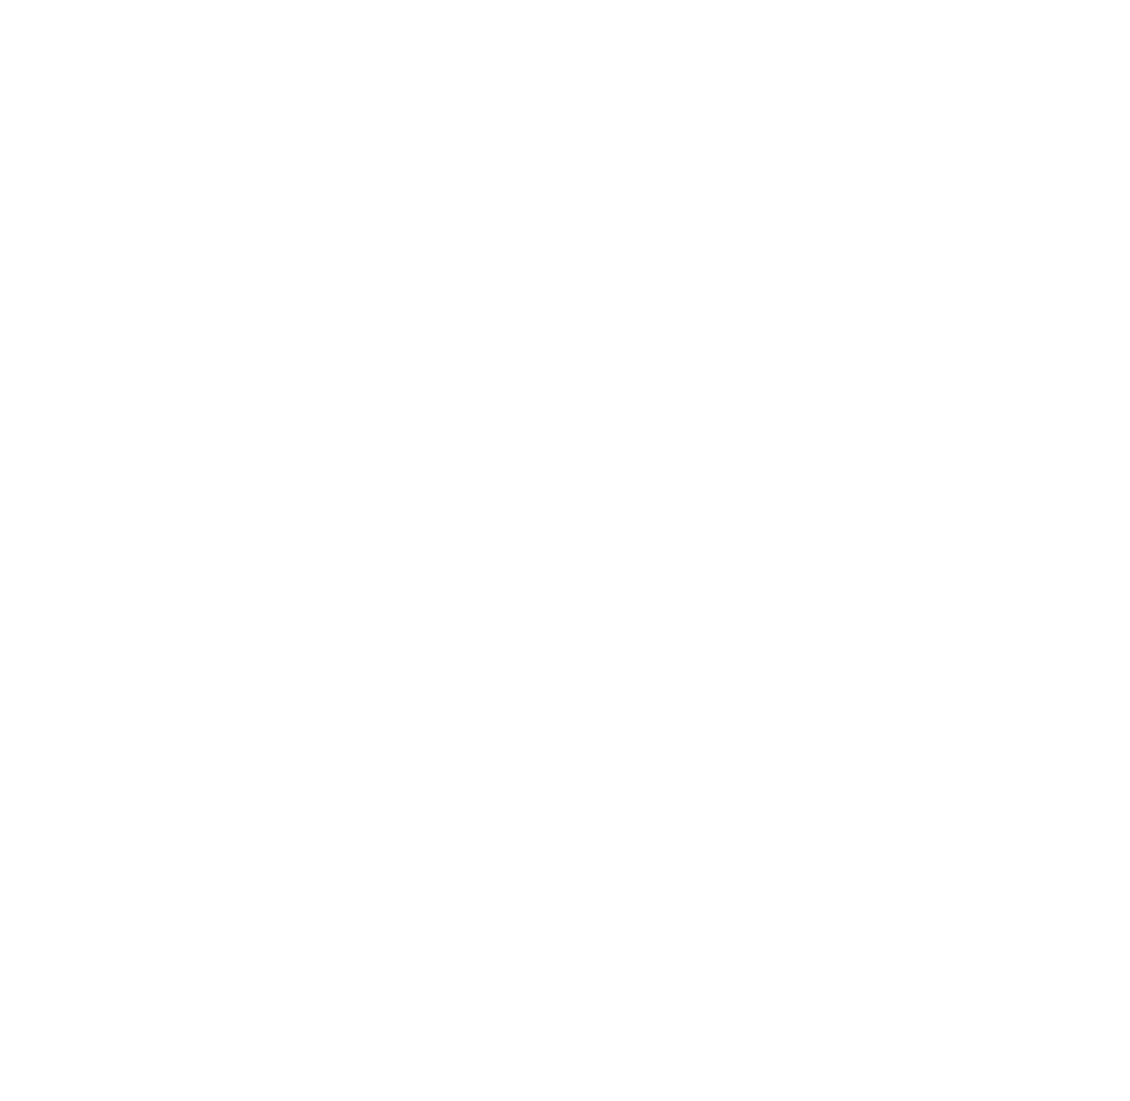

In [11]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(regressor.estimators_[0], 
                   feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],
                   filled=True)

In [13]:
dot_data = export_graphviz(regressor.estimators_[0],
                           feature_names=['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha'],  
                           filled=True, rounded=True)  

graph = graphviz.Source(dot_data, format='png')
graph.render("tree") 

KeyboardInterrupt: 

From here it is problematic: using 100 as number of trees and using 30% of the data results in using already almost all the ram (16Gb).

## Tuning of the hyperparameters
First we do a random grid search

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 20, cv = 3, verbose=3, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
with sys_pipes():
    rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
def evaluate_accuracy(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate_accuracy(best_random, X_test, Y_test)

In [ ]:
best_random

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

### Using XGBoost

In [6]:
# definition of the model 
model = XGBRFRegressor(n_jobs=-1, verbosity=3)

# traininig of the model
model.fit(X_train, Y_train)

[08:50:03] DEBUG: ../src/gbm/gbtree.cc:155: Using tree method: 2
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[08:50:12] INFO: ../src/tree/updater_pr

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, enable_categorical=False, gamma=0, gpu_id=-1,
               importance_type=None, interaction_constraints='',
               max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=100, n_jobs=-1,
               num_parallel_tree=100, objective='reg:squarederror',
               predictor='auto', random_state=0, reg_alpha=0,
               scale_pos_weight=1, tree_method='exact', validate_parameters=1,
               verbosity=3)

In [7]:
# make predictions to compare with Y_test
Y_pred = model.predict(X_test)

print('Score of the regressor for the training set:\n', model.score(X_train, Y_train))
print('\nScore of the regressor for the test set:\n',   model.score(X_test,  Y_test ))
print('R^2 Score of the regressor for the test set:\n', r2_score(Y_test,  Y_pred ))
print('Mean squared log error of the regressor for the test set:\n', mean_squared_log_error(Y_test,  Y_pred ))
print('Mean squared error of the regressor for the test set:\n', mean_squared_error(Y_test,  Y_pred ))

Score of the regressor for the training set:
 -2.7754687437209213e-11

Score of the regressor for the test set:
 -0.000753809519580928
R^2 Score of the regressor for the test set:
 -0.000753809519580928
Mean squared log error of the regressor for the test set:
 620.9508979970574
Mean squared error of the regressor for the test set:
 2.4285340406946983e+40


invalid value encountered in true_divide
Data has no positive values, and therefore cannot be log-scaled.


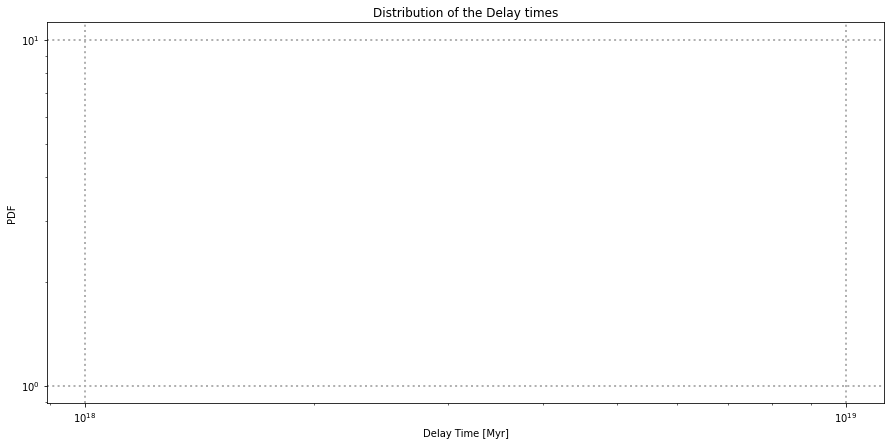

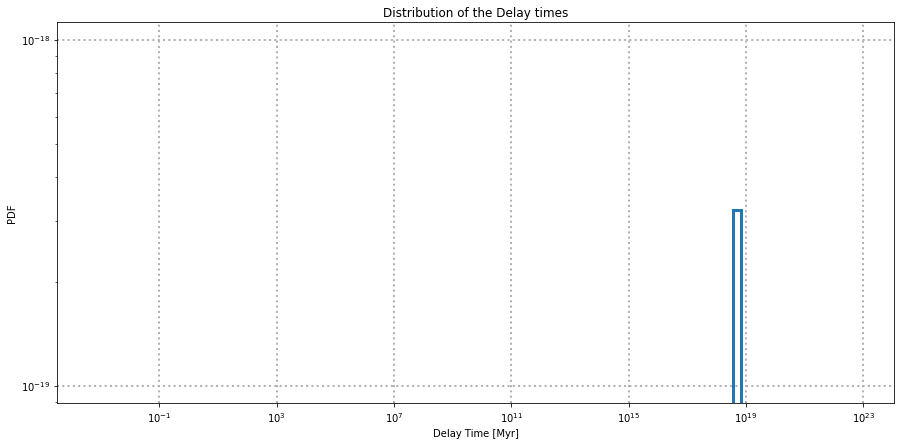

In [16]:
plot_hist(Y_pred, 100)
plot_hist(Y_test, 100)

In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = XGBRFRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               n_iter = 20, cv = 3, verbose=3, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
with sys_pipes():
    rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ubuntu/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.In

### Using Tensorflow

In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

2022-05-30 13:38:31.107482: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-05-30 13:38:31.113666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 13:38:31.113683: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
"""### Normalization over the whole dataset

features_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

min_value = np.min (np.min (features_all, axis=0))
max_value = np.max (np.max (features_all, axis=0))
avg_value = np.mean(np.mean(features_all, axis=0))
std_value = np.std (np.std (features_all, axis=0))

method = 'norm'  #norm, std, log

def normalizer(x):
    if method == 'norm':
        return (x-min_value)/(max_value-min_value)
    elif method =='std':
        return (x- avg_value)/std_value
    elif method =='log':
        return np.log10(x)

features_all = features_all.apply(normalizer)"""

"### Normalization over the whole dataset\n\nfeatures_all = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]\n\nmin_value = np.min (np.min (features_all, axis=0))\nmax_value = np.max (np.max (features_all, axis=0))\navg_value = np.mean(np.mean(features_all, axis=0))\nstd_value = np.std (np.std (features_all, axis=0))\n\nmethod = 'norm'  #norm, std, log\n\ndef normalizer(x):\n    if method == 'norm':\n        return (x-min_value)/(max_value-min_value)\n    elif method =='std':\n        return (x- avg_value)/std_value\n    elif method =='log':\n        return np.log10(x)\n\nfeatures_all = features_all.apply(normalizer)"

### Normalization of the data

In [8]:
### Normalization of each column
features = BHBH[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha', 'Delay_Time']]

# min-max normalization
features = (features-features.min())/(features.max()-features.min())

# mean normalization
#features=(features-features.mean())/features.std()

### Split in training and validation

In [9]:
# Split the dataset into a training and a testing dataset.
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [10]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset=features,
                                        test_ratio=.5)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

1026974 examples in training, 1028066 examples for testing.


In [11]:
X_train = train_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_train = train_ds_pd.Delay_Time.to_numpy()

X_test  = test_ds_pd[['Mass_0', 'Mass_1', 'Semimajor', 'Eccentricity', 'Z', 'alpha']].to_numpy()
Y_test  = test_ds_pd.Delay_Time.to_numpy()

### Training of the model

In [12]:
# Configure the model.
model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)
# Configure the metrics (Eventually add other metrics).
#model.compile(metrics=["mse", "mape"])
model.compile(metrics=["mse"])
# Train the model.
with sys_pipes():
    #model.fit(x=train_ds)
    model.fit(X_train, Y_train)

Use /tmp/tmpvilw39x3 as temporary training directory


2022-05-30 13:51:43.672715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-30 13:51:43.672779: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-30 13:51:43.672817: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lcpb-aidinattar): /proc/driver/nvidia/version does not exist
2022-05-30 13:51:43.673215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Reading training dataset...
Training dataset read in 0:00:05.051459. Found 1026974 examples.
Training model...


2022-05-30 13:51:48.929662: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at kernel.cc:952 : UNKNOWN: TensorFlow: INVALID_ARGUMENT: The number of threads should be >= 0


UnknownError: TensorFlow: INVALID_ARGUMENT: The number of threads should be >= 0 [Op:SimpleMLModelTrainer]

In [27]:
model.summary()

Model: "random_forest_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	data:0.0
	data:0.1
	data:0.2
	data:0.3
	data:0.4
	data:0.5

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "__LABEL" 13.974898 ################
    2. "data:0.5" 13.798353 ###############
    3. "data:0.1"  7.974205 ########
    4. "data:0.3"  5.734435 #####
    5. "data:0.4"  4.073616 ###
    6. "data:0.0"  2.659911 #
    7. "data:0.2"  1.310174 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 130.000000 ################
    2. "data:0.2" 109.000000 #############
    3. "data:0.3" 38.000000 ####
    4. "data:0.4" 16.000000 #
    5. "data:0.1"  7.000000 

Variable Importance: NUM_NODES:
    1. "data:0.2" 125078

In [28]:
# inspect the features used in the model
model.make_inspector().features()

["data:0.0" (1; #0),
 "data:0.1" (1; #1),
 "data:0.2" (1; #2),
 "data:0.3" (1; #3),
 "data:0.4" (1; #4),
 "data:0.5" (1; #5)]

In [29]:
#evaluation = model.evaluate(test_ds, return_dict=True)
evaluation = model.evaluate(X_test, Y_test, return_dict=True)

print(evaluation)
print(f"MSE: {evaluation['mse']:.2f}")
print(f"RMSE: {np.sqrt(evaluation['mse']):.2f}")
#print(f"MAPE: {evaluation['mape']:.2f}")

32084/32084 [==============================] - 50s 2ms/step - loss: 0.0000e+00 - mse: 1.0784e-06
{'loss': 0.0, 'mse': 1.0783564903249498e-06}
MSE: 0.00
RMSE: 0.00


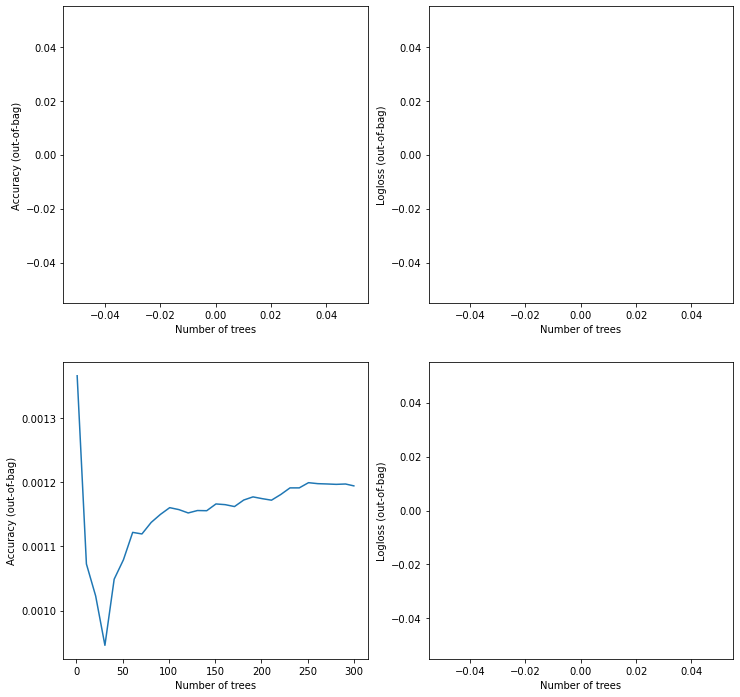

In [30]:
logs = model.make_inspector().training_logs()

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12, 12))

ax[0,0].plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
ax[0,0].set_xlabel("Number of trees")
ax[0,0].set_ylabel("Accuracy (out-of-bag)")
ax[0,1].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
ax[0,1].set_xlabel("Number of trees")
ax[0,1].set_ylabel("Logloss (out-of-bag)")
ax[1,0].plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
ax[1,0].set_xlabel("Number of trees")
ax[1,0].set_ylabel("Accuracy (out-of-bag)")
ax[1,1].plot([log.num_trees for log in logs], [log.evaluation.ndcg for log in logs])
ax[1,1].set_xlabel("Number of trees")
ax[1,1].set_ylabel("Logloss (out-of-bag)")
plt.show()


# ????
# Why loss and accuracy are zero?
# Maybe something missing

In [40]:
# make predictions to compare with Y_test
#Y_pred = model.predict(test_ds)
Y_pred = model.predict(X_test)

32084/32084 [==============================] - 47s 1ms/step


In [44]:
(Y_pred, Y_test)

(array([[2.0982714e-10],
        [3.9613801e-10],
        [4.5093010e-10],
        ...,
        [7.9357788e-12],
        [5.6338250e-12],
        [7.9357788e-12]], dtype=float32),
 array([5.85615883e-20, 4.16550015e-19, 3.51363722e-15, ...,
        3.69902602e-21, 4.82414339e-27, 9.79715545e-23]))

In [37]:
epsilon = 1e-28

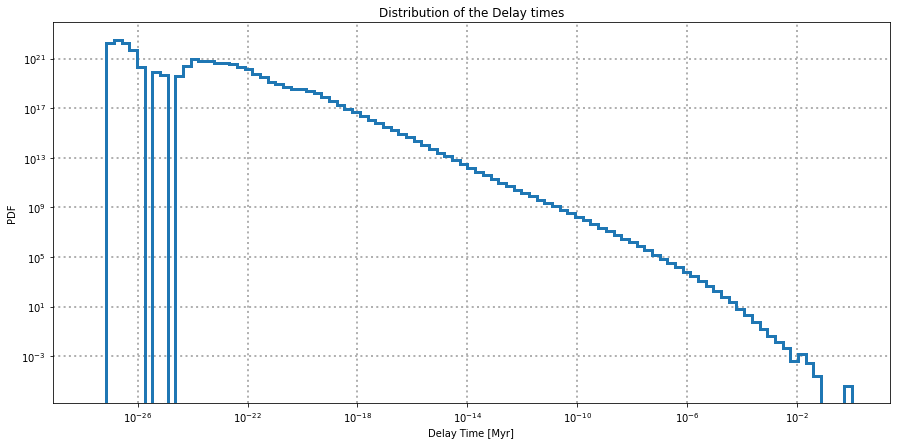

In [41]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_test)+epsilon), np.log10(max(Y_test)), 100)
entries, edges, _ = ax.hist(Y_test, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

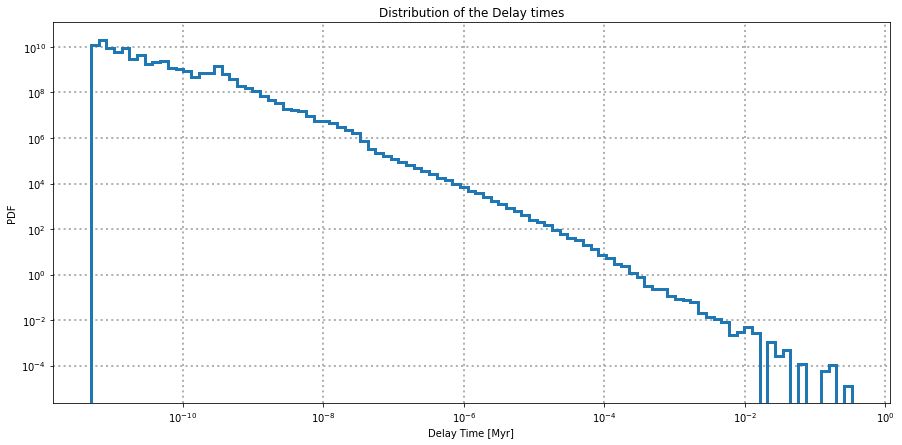

In [42]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(Y_pred)), np.log10(max(Y_pred)), 100)
b = np.concatenate(b, axis=0)
entries, edges, _ = ax.hist(Y_pred, bins=b, density=True, histtype='step', lw=3)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted', lw=2)

In [116]:
# plot the first tree, restricted to depth of 3
tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_c9f9d4664ba8485d95fb6fd50270894f"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

In [17]:
# Number of trees in random forest
num_trees = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
num_candidate_attributes = [-1, 0, 3]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_examples = [2, 5, 10, 50]

# Minimum number of samples required at each leaf node
uplift_min_examples_in_treatment = [1, 2, 4, 5, 10]

# Method of selecting samples for training each tree
adapt_bootstrap_size_ratio_for_maximum_training_duration = [True, False]

# Create the random grid
random_grid = {'num_trees': num_trees,
               'num_candidate_attributes': num_candidate_attributes,
               'max_depth': max_depth,
               'min_examples': min_examples,
               'uplift_min_examples_in_treatment': uplift_min_examples_in_treatment,
               'adapt_bootstrap_size_ratio_for_maximum_training_duration': adapt_bootstrap_size_ratio_for_maximum_training_duration}
random_grid

{'num_trees': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'num_candidate_attributes': [-1, 0, 3],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_examples': [2, 5, 10, 50],
 'uplift_min_examples_in_treatment': [1, 2, 4, 5, 10],
 'adapt_bootstrap_size_ratio_for_maximum_training_duration': [True, False]}

In [28]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = KerasClassifier(model=tfdf.keras.RandomForestModel, task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, 
                               scoring='accuracy',
                               n_iter = 20, cv = 3, verbose=0, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

/tmp/ipykernel_4151/1691860955.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rf = KerasClassifier(model=tfdf.keras.RandomForestModel, task = tfdf.keras.Task.REGRESSION, num_threads=n_threads)


AttributeError: 'KerasClassifier' object has no attribute '__call__'

In [3]:
"""for deeptnote"""
# def slice_dataset(dataset, slice_ratio=0.15):
#   valid_indices = np.random.rand(len(dataset)) < slice_ratio
#   return dataset[valid_indices]
# BHBH_sliced = slice_dataset(BHBH)
# BHBH_sliced.to_csv('dataset.csv')